# Student Test Scores challenge - Predicting scores on students
---

**Author**: [fsb2210](https://www.kaggle.com/fsb2210)

## Introduction

In this notebook we develop a linear predictive model, Ridge, in order to estimate test scores for different students using several different features such as demography, environment, behavior.

The dataset contains a mix of categorical and numerical features.

Import packages to be used throughout the notebook:

In [348]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
import optuna
from xgboost import XGBRegressor

Define options:

In [349]:
# filenames
train_filename: str = "KaggleData/playground-series-s6e1/train.csv"
test_filename: str = "KaggleData/playground-series-s6e1/test.csv"

# split train dataset into train & valid subsets using this fraction
valid_split = 0.15

random_state: int = 42

# set random seed
np.random.seed(random_state)

## Data loading

Now we are able to load the training sample and split it between a training & validation subsets:

In [350]:
train_df = pd.read_csv(train_filename)
test_df = pd.read_csv(test_filename)

ordinal_categories = {
    "sleep_quality": ["poor", "medium", "good"],
    "facility_rating": ["low", "medium", "high"],
    "exam_difficulty": ["easy", "moderate", "hard"]
}

quality_map = {"poor": 0, "medium": 1, "good": 2}
train_df['sleep_num'] = train_df['sleep_quality'].map(quality_map)
test_df['sleep_num'] = test_df['sleep_quality'].map(quality_map)

train_df['study_sleep_power'] = train_df['study_hours'] * train_df['sleep_num']
test_df['study_sleep_power'] = test_df['study_hours'] * test_df['sleep_num']

In [351]:
X = train_df.drop(["id", "exam_score"], axis=1)
y = train_df["exam_score"]

numerical_cols = ["age", "study_hours", "class_attendance", "sleep_hours","study_sleep_power"]
nominal_cols = ["gender","internet_access","course","study_method"]
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=valid_split, random_state=random_state,
)

In [352]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_cols),
        ("nominal", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), nominal_cols),
        ("ordinal", OrdinalEncoder(
            categories=[ordinal_categories[col] for col in ordinal_cols],
            handle_unknown="use_encoded_value",
            unknown_value=-1,  # for unseen categories assign this
        ), ordinal_cols)
    ],
    remainder="passthrough",
)

In [353]:
# X_train_pre = preprocessor.fit_transform(X_train)
# X_valid_pre = preprocessor.transform(X_valid)

# def objective(trial):
#     param = {
#         'n_estimators': 5000,
#         'learning_rate': 0.01,
#         'max_depth': 6,
#         'early_stopping_rounds': 50,
#         'random_state': random_state,
#         'n_jobs': -1,
#         'subsample': trial.suggest_float('subsample', 0.7, 0.9),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        
#     }
#     model = XGBRegressor(**param)
    
#     model.fit(
#         X_train_pre, y_train,
#         eval_set=[(X_valid_pre, y_valid)],
#         verbose=False
#     )
    
#     preds = model.predict(X_valid_pre)
#     rmse = root_mean_squared_error(y_valid, preds)
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print("Best Score:", study.best_value)
# print("Best Params:", study.best_params)

In [354]:
model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=6,
    early_stopping_rounds=50,
    subsample=0.8101244662874618,
    colsample_bytree=0.8882463739383992,
    random_state=random_state,
    n_jobs=-1,
    verbosity=0,
)

In [355]:
X_train_pre = preprocessor.fit_transform(X_train)
X_valid_pre = preprocessor.transform(X_valid)

model.fit(
    X_train_pre, y_train,
    eval_set=[(X_valid_pre, y_valid)],
    verbose=200
)

[0]	validation_0-rmse:18.71416
[200]	validation_0-rmse:9.73304
[400]	validation_0-rmse:8.93861
[600]	validation_0-rmse:8.80423
[800]	validation_0-rmse:8.77967
[1000]	validation_0-rmse:8.77042
[1200]	validation_0-rmse:8.76312
[1400]	validation_0-rmse:8.75601
[1600]	validation_0-rmse:8.75000
[1800]	validation_0-rmse:8.74484
[2000]	validation_0-rmse:8.74029
[2200]	validation_0-rmse:8.73636
[2400]	validation_0-rmse:8.73259
[2600]	validation_0-rmse:8.72980
[2800]	validation_0-rmse:8.72706
[3000]	validation_0-rmse:8.72476
[3200]	validation_0-rmse:8.72279
[3400]	validation_0-rmse:8.72069
[3600]	validation_0-rmse:8.71901
[3800]	validation_0-rmse:8.71747
[4000]	validation_0-rmse:8.71629
[4200]	validation_0-rmse:8.71498
[4400]	validation_0-rmse:8.71379
[4600]	validation_0-rmse:8.71265
[4800]	validation_0-rmse:8.71181
[4999]	validation_0-rmse:8.71100


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8882463739383992, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=-1,
             num_parallel_tree=None, ...)

In [356]:
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ## ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
#     ("model", model)
# ])
# pipeline.fit(
#     X_train, y_train,
#     model__eval_set=[(pipeline.named_steps['preprocessor'].transform(X_valid), y_valid)], 
#     model__verbose=100
#     )

In [357]:
def score_model(model, X, y):
    """Evaluate the trained model and returns a dictionary with eval metrics"""
    # make predictions
    y_pred = model.predict(X)
    # return metrics & predictions
    return {
        "mse": mean_squared_error(y, y_pred),
        "rmse": root_mean_squared_error(y, y_pred),
        "r2": r2_score(y, y_pred),
        "y_pred": y_pred,
    }

In [358]:
score = score_model(model, X_valid_pre, y_valid)
print(f"mean squared error (MSE): {score['mse']:.4f}")
print(f"root mean squared error (RMSE): {score['rmse']:.4f}")
print(f"R2: {score['r2']:.4f}")

mean squared error (MSE): 75.8815
root mean squared error (RMSE): 8.7110
R2: 0.7863


In [359]:
history = [
    {"date": "1/8", "feature": "XGBoost_BaseLine", "valid_rmse": 8.7289, "kaggle": 8.73108, "memo": "初提出"},
    {"date": "1/8", "feature": "study * sleep", "valid_rmse": 8.7226, "kaggle":None , "memo": "効果あり"},
    {"date": "1/8", "feature": "study_log_and_sq", "valid_rmse": 8.7225, "kaggle":None , "memo": "効果なし"},
    {"date": "1/8", "feature": "study*attendance", "valid_rmse": 8.7273, "kaggle":None , "memo": "わずかに悪化"},
    {"date": "1/8", "feature": "minus_gender_internet_access_course", "valid_rmse": 8.7319, "kaggle":None , "memo": "わずかに悪化"},
    {"date": "1/8", "feature": "depth_8", "valid_rmse": 8.74085, "kaggle":None , "memo": "わずかに悪化"},
    {"date": "1/8", "feature": "depth_7", "valid_rmse": 8.73314, "kaggle":None , "memo": "わずかに悪化"},
    {"date": "1/8", "feature": "depth_5", "valid_rmse": 8.72829, "kaggle":None , "memo": "わずかに悪化"},
    {"date": "1/8", "feature": "depth_4", "valid_rmse": 8.74540, "kaggle":None , "memo": "わずかに悪化"},
    {"date": "1/8", "feature": "subsample=0.8_colsample_bytree=0.8", "valid_rmse": 8.71274, "kaggle":8.71360, "memo": "効果あり"},
    {"date": "1/8", "feature": "subsample_0.8101244662874618_colsample_bytree_0.8882463739383992", "valid_rmse": 8.71100, "kaggle":None , "memo": "効果あり"}


]
display(pd.DataFrame(history))

,date,feature,valid_rmse,kaggle,memo
0,1/8,XGBoost_BaseLine,8.72890,8.73108,初提出
1,1/8,study * sleep,8.72260,NaN,効果あり
2,1/8,study_log_and_sq,8.72250,NaN,効果なし
3,1/8,study*attendance,8.72730,NaN,わずかに悪化
4,1/8,minus_gender_internet_access_course,8.73190,NaN,わずかに悪化
5,1/8,depth_8,8.74085,NaN,わずかに悪化
6,1/8,depth_7,8.73314,NaN,わずかに悪化
7,1/8,depth_5,8.72829,NaN,わずかに悪化
8,1/8,depth_4,8.74540,NaN,わずかに悪化
9,1/8,subsample=0.8_colsample_bytree=0.8,8.71274,8.71360,効果あり


Visualize predictions and compare them to ground truth:

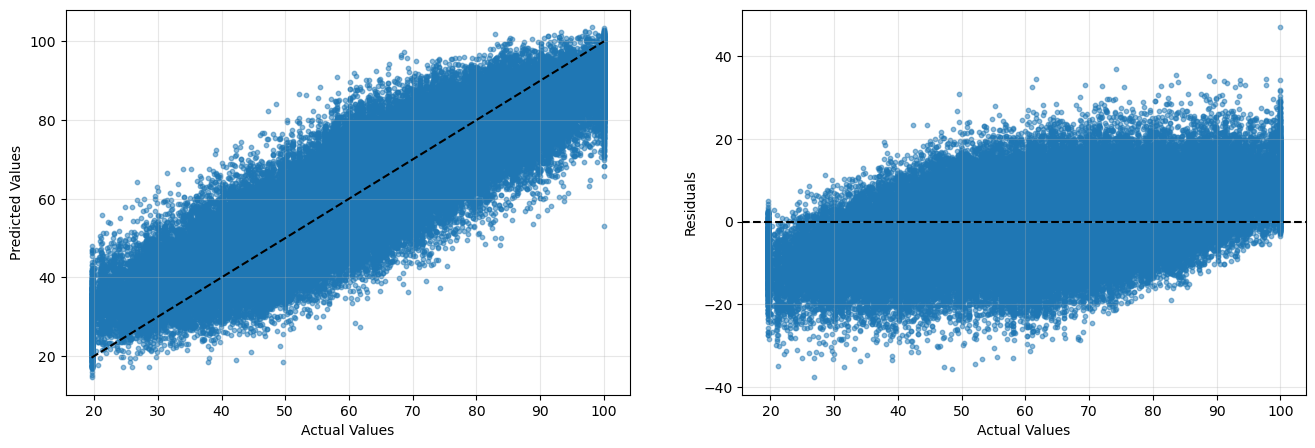

In [360]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

y_pred = score["y_pred"]

# 1. Actual vs Predicted
axes[0].scatter(y_valid, y_pred, alpha=0.5, s=10)
axes[0].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color="black", linestyle="--")
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals = y_valid - y_pred
axes[1].scatter(y_valid, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color="black", linestyle="--")
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

There is a lot of spread around the dashed line representing a "perfect" match with the ground truth. Also something is happening at the boundaries...

First model to try and it doesn't seem to be a good fit! :-/

## Inference

We can finally make predictions on the test set and use them to submit a file to the competition:

In [361]:
test_df.head(n=2)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,sleep_num,study_sleep_power
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy,0.0,0.0
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy,0.0,0.0


Make predictions on test set, the pipeline takes care of encode and scale values in each of the corresponding columns:

In [362]:
X_test_pre = preprocessor.transform(test_df)
preds = model.predict(X_test_pre)

### Submission


Create DataFrame and submit file to competition:

In [363]:
sub_df = pd.DataFrame({"id": test_df.id, "exam_score": preds})
sub_df.to_csv("submission.csv", index=False)
sub_df.head(n=2)

,id,exam_score
0,630000,71.03508
1,630001,69.91629


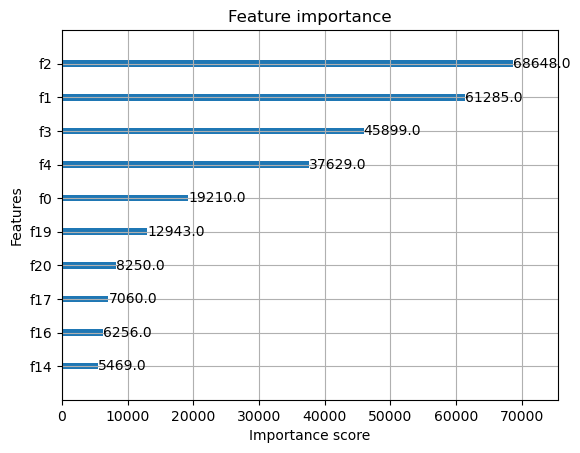

In [364]:
from xgboost import plot_importance

# パイプラインを使っている場合、最後のステップ（model）を取り出す
plot_importance(model, max_num_features=10) # 上位10個を表示
plt.show()

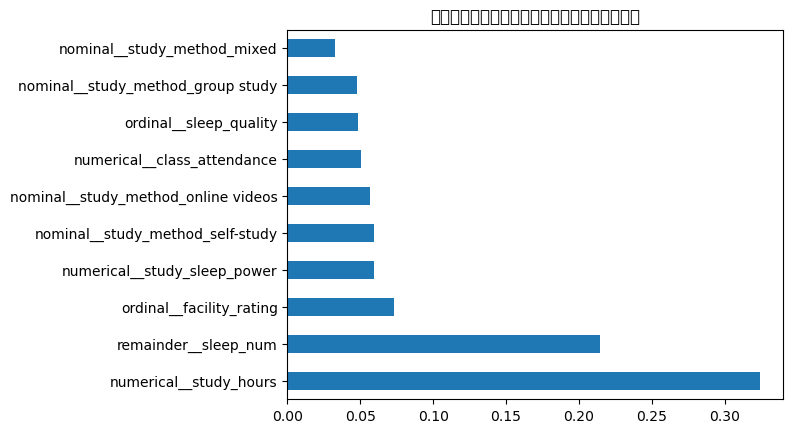

In [365]:
# 前処理（ColumnTransformer）から、変換後の列名を取得する
feature_names = preprocessor.get_feature_names_out()

# モデルから重要度を取り出す
importances = model.feature_importances_

# 見やすいグラフにする
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("どのデータが予測に効いているか（名前付き）")
plt.show()

In [366]:
# Validデータでの予測値と実測値の差を計算
X_valid['actual'] = y_valid
X_valid['predict'] = pipeline.predict(X_valid)
X_valid['error'] = abs(X_valid['actual'] - X_valid['predict'])

# 誤差が大きい順に並べて表示
print(X_valid.sort_values('error', ascending=False).head(5))

NotFittedError: Pipeline is not fitted yet.

「ターゲット・エンコーディング」を試してみる： 「学校名」や「出身地」のような、種類が多い文字データを、単なる数字（1, 2, 3...）ではなく、**「そのグループの平均点」**に置き換える手法です。これはXGBoostと非常に相性が良く、劇的に効くことがあります。
特徴量エンジニアリング（一番効く！）

例えば「試験科目ごとの合計」や「去年の成績との差」など、新しい列を作ってみる。
「特定の科目が0点の人」など、異常なパターンにフラグを立ててみる。
特徴量の重要度（Feature Importance）を確認

他のモデルとのアンサンブル

XGBoostだけでなく、LightGBMやRandomForestの結果を「平均」してみる（これでスコアが0.01刻みで上がることがよくあります）。

まとめる: 「B.Sc（理学士）」とか細かいコース名で効いていないなら、「理系・文系」というもっと大きな枠組みに作り直してみるのも手です。

「施設の評価 ÷ 学費」

「24時間 - 睡眠時間 = 活動時間（起きている時間）」

この活動時間のうち、**「どれくらいを勉強に充てたか（勉強の比率）」**が重要かもしれません。

「活動時間 - 勉強時間 = 自由時間（リラックス時間）」

勉強ばかりしてリラックス（自由時間）が全くない人は、逆に効率が落ちてスコアが低い…といった「人間らしいパターン」をモデルが探せるようになります。

プランB：ターゲット（y）の加工

「スコアそのもの」を予測するのではなく、「スコアのログ（np.log1p）」を予測して、最後に元に戻す（np.expm1） という手法です。